In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(12, 6)})

We'll start our process by reading in the scarped results and conducting some data transformations and other changes to clean the date.

In [3]:
records = pd.read_csv('scraped_results_df.csv')

In [4]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48899 entries, 0 to 48898
Data columns (total 13 columns):
Unnamed: 0     48899 non-null int64
row            48899 non-null int64
week_number    48899 non-null int64
winner         48899 non-null object
winner_pts     48897 non-null float64
loser          48899 non-null object
loser_pts      48897 non-null float64
game_date      48899 non-null object
game_time      5225 non-null object
game_day       48899 non-null object
game_loc       17923 non-null object
notes          4066 non-null object
year           48899 non-null int64
dtypes: float64(2), int64(4), object(7)
memory usage: 4.9+ MB


In [5]:
records.describe()

Unnamed: 0           row   week_number    winner_pts     loser_pts  \
count  48899.000000  48899.000000  48899.000000  48897.000000  48897.000000   
mean     360.076361    361.076361      7.479539     31.192159     13.981389   
std      215.386657    215.386657      3.950671     13.186025      9.711082   
min        0.000000      1.000000      1.000000      0.000000      0.000000   
25%      177.000000    178.000000      4.000000     21.000000      7.000000   
50%      354.000000    355.000000      7.000000     30.000000     13.000000   
75%      531.000000    532.000000     10.000000     40.000000     20.000000   
max      883.000000    884.000000     21.000000    100.000000     72.000000   

               year  
count  48899.000000  
mean    1985.805047  
std       19.962510  
min     1950.000000  
25%     1969.000000  
50%     1985.000000  
75%     2004.000000  
max     2018.000000

In [6]:
records.tail()

Unnamed: 0  row  week_number                winner  winner_pts  \
48894         879  880           21         (16) Kentucky        27.0   
48895         880  881           21  (11) Louisiana State        40.0   
48896         881  882           21        (5) Ohio State        28.0   
48897         882  883           21            (14) Texas        28.0   
48898         883  884           21           (2) Clemson        44.0   

                     loser  loser_pts    game_date game_time game_day  \
48894      (13) Penn State       24.0  Jan 1, 2019   1:00 PM      Tue   
48895  (7) Central Florida       32.0  Jan 1, 2019   1:00 PM      Tue   
48896       (9) Washington       23.0  Jan 1, 2019   5:00 PM      Tue   
48897          (6) Georgia       21.0  Jan 1, 2019   8:45 PM      Tue   
48898          (1) Alabama       16.0  Jan 7, 2019   8:00 PM      Mon   

      game_loc                                              notes  year  
48894      NaN  Citrus Bowl (Camping World Stadium - Orlando, ...  2018  
48895      NaN  Fiesta Bowl (State Farm Stadium - Glendale, Ar...  2018  
48896      NaN       Rose Bowl (Rose Bowl - Pasadena, California)  2018  
48897      NaN  Sugar Bowl (Mercedes-Benz Superdome - New Orle...  2018  
48898      NaN  College Football Championship (Levi's Stadium ...  2018

We've got some data cleaning to do and theres some additional data fields that I'd like to calculate.  The below code cell cleans up some column names, separates the rank from the team name, determines a "rank_diff" score when ranked teams play each other, a "pts_diff" score to track the points difference in the game, and sets a multi-index on year, week of the season, and individual game.

In [7]:
records = pd.read_csv('scraped_results_df.csv')
# 'game_loc' indicated where the game was played at. Since the winner is listed first in 
# the original data, the '@' indicates the game was played at the loser's home.  Therefore, 
# we can create a new column called 'Winner_home' if the '@' sign is not present.
records['winner_home'] = records['game_loc']!='@'

# The rank is included in the winner and losers name within parenthesis.  The below regex will identify 
# numerical digits within the parenthesis and extract them to a new column as 'floats'.  We'll also 
# remove the rank in parenthesis from the original winner column.  We'll do this for winners and losers.
records['winner_rank'] = records['winner'].str.extract('\(([0-9]+)\)', expand=True).astype('float')
records['winner_name'] = records['winner'].str.replace('\(([0-9]+)\)', '').str.replace('\xa0', '')
records['loser_rank'] = records['loser'].str.extract('\(([0-9]+)\)', expand=True).astype('float')
records['loser_name'] = records['loser'].str.replace('\(([0-9]+)\)', '').str.replace('\xa0', '')

# Calculate a rank_diff socre.  The more negative this is, the more of an upset it is.
records['rank_diff'] = records['loser_rank'] - records['winner_rank']

# Add a pts_diff between the two pts as we can use margin of victory to see how close a 
# game is.
records['pts_diff'] = records['winner_pts'] - records['loser_pts']

# We no longer need several of these columns, so lets drop them.  
records.drop(['Unnamed: 0', 'winner','loser'], axis=1, inplace=True)

records.set_index(['year','week_number', 'row'], inplace=True)

## Data Exploration and Analysis

From the below plot, we can see a tremendous explosion in number of games in the 1970's.  In fact in 1977, the NCAA split into 1A for larger schools with better football teams and 1AA for smaller schools.  In recent years, part of the rise in number of games has been a proliferation of games played after the normal season, including bowl games and playoffs.

Text(0.5, 0, 'Year')

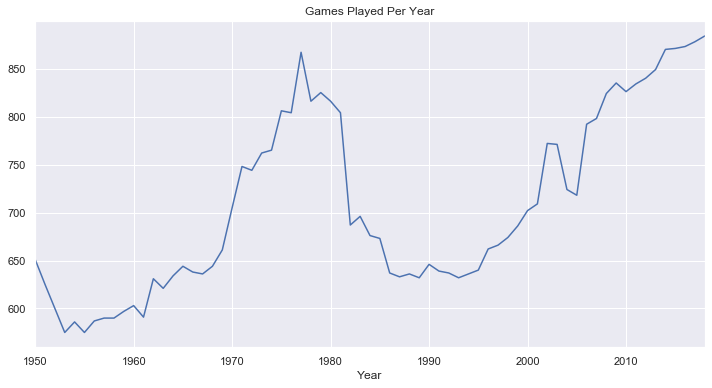

In [8]:
ax = records.groupby('year').size().plot(figsize=(12,6), title='Games Played Per Year')
ax.set_xlabel('Year')

This plot shows how many games are played in each week.  The small number of games played after week 12 relative to the rest of the year highlights both a longer season in recent years and the growth in "post-season" bowl games, conference champions, and most recently play-off games

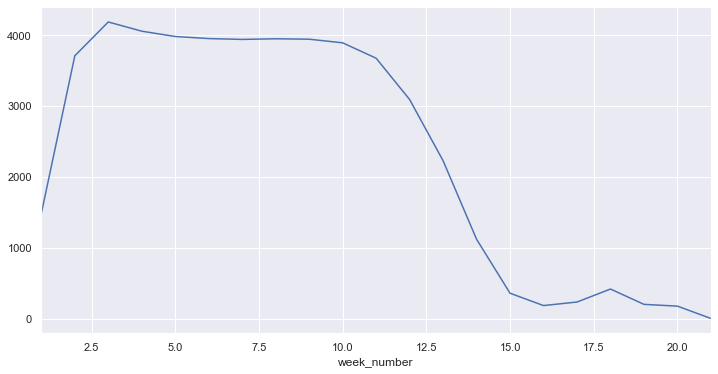

In [9]:
# total number of games per week
records.groupby('week_number').size().plot()

By looking at the distribution of winner points, loser points, difference between points, and the rank difference over the entire data, several trends emerge.  First, winner points (the total number of points a winner scores) is mostly normally distributed.  On the other hand, the loser's points and the points difference are dramatically skewed to the right with most losers scoring less than 15 points and points differences less then 20.   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dd58990>,
      dtype=object)

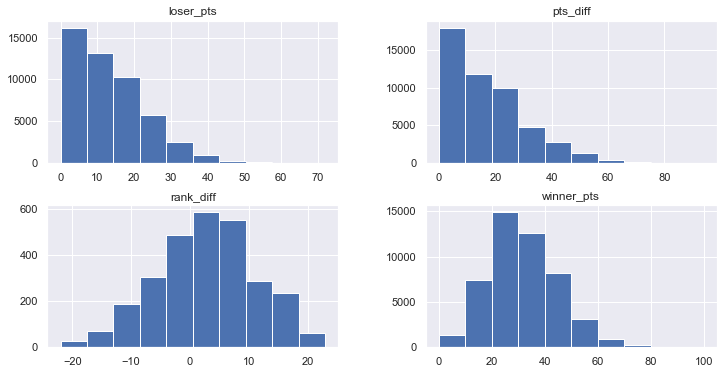

In [10]:
records[['winner_pts', 'loser_pts', 'pts_diff', 'rank_diff']].hist(figsize=(12,6))


By looking at points scored by the winners, losers, and the difference, we can see that over time more points have been scored by both teams.  However, the average points difference has remained relatively stead over the last 70 years.

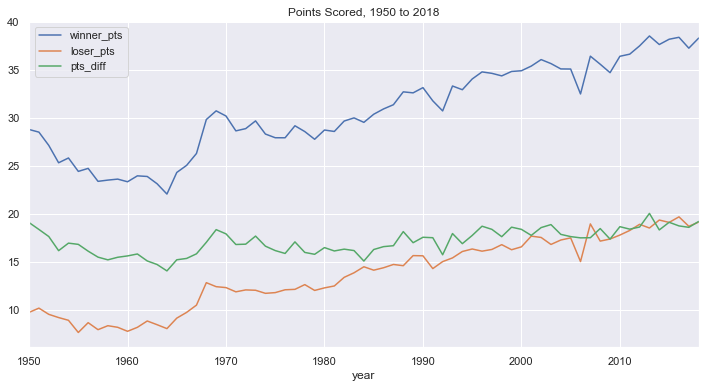

In [11]:
records.groupby('year').mean().plot(y=['winner_pts','loser_pts','pts_diff'], title="Points Scored, 1950 to 2018")

If we want to look at how "accurate" the polls have been when ranked teams play each other, we could look at the rank difference between the two teams.  We would expect a positive score as that means the higher ranked team defeated the lower ranked team.  The plot below shows the variability of the average rank difference score over the last 70 years. 

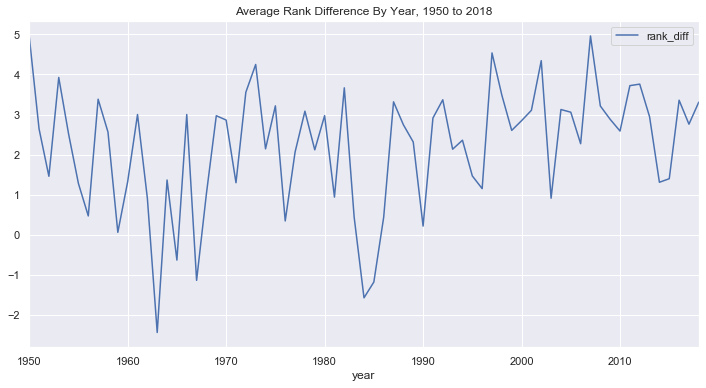

In [12]:
records.groupby('year').mean().plot(y='rank_diff', title="Average Rank Difference By Year, 1950 to 2018")

If we look at the rank difference averaged across each week, we see a far higher accuracy in the first 15 weeks wieht a score averaging between +2 and +3, before dropping to almost -2.  This is likley because it is far more difficult to pick the winner in closely matched games in the post-season when conference championships and bowl games occur.

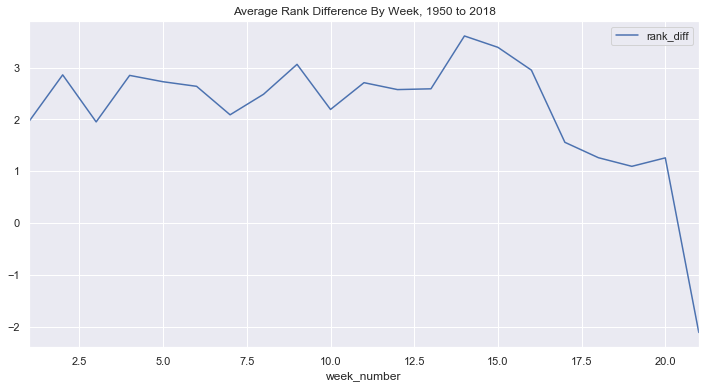

In [13]:
records.groupby('week_number').mean().plot(y='rank_diff', title="Average Rank Difference By Week, 1950 to 2018")

By plotting points difference against the rank difference, we see that the more positive the rank difference, the greater the margin of victory.  This makes sense when a higher ranked team plays and defeats a lower ranked team, the bigger difference in the rank leads to a more severe points difference.  However, this scatter plot does not work well with dense data like this.  Let's try using a hexplot from Seaborn.

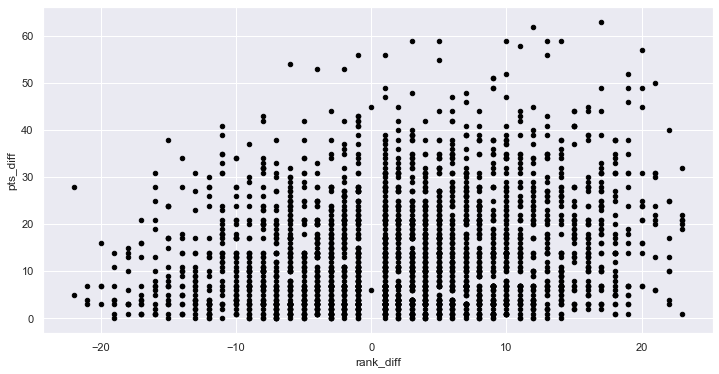

In [14]:
records.plot(x='rank_diff', y='pts_diff', kind='scatter', c='black')

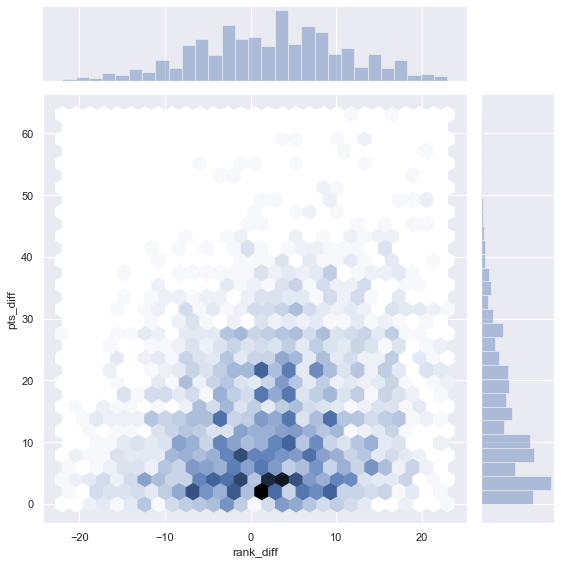

In [15]:
sns.jointplot(x='rank_diff', y='pts_diff', data=records, kind='hex', height=8)

Using the rank difference field, we can look for the biggest upsets between ranked teams.  A more negative rank difference indicates a more dramatic upset.  Next we can look at when unranked teams beat the number one ranked team.

In [16]:
# Biggest upsets between ranked teams
records[records['rank_diff'] < -18].sort_values('rank_diff')[:5]

winner_pts  loser_pts     game_date game_time game_day  \
year week_number row                                                           
1995 11          447        33.0       28.0   Nov 2, 1995       NaN      Thu   
2015 5           309        38.0       10.0   Oct 3, 2015   7:00 PM      Sat   
2017 10          539        14.0        7.0  Oct 28, 2017   3:30 PM      Sat   
2014 9           514        10.0        7.0  Oct 25, 2014   7:15 PM      Sat   
     6           378        37.0       33.0   Oct 4, 2014   3:30 PM      Sat   

                     game_loc                            notes  winner_home  \
year week_number row                                                          
1995 11          447      NaN                              NaN         True   
2015 5           309      NaN                              NaN         True   
2017 10          539      NaN  Jack Trice Stadium - Ames, Iowa         True   
2014 9           514      NaN                              NaN         True   
     6           378      NaN                              NaN         True   

                      winner_rank      winner_name  loser_rank  \
year week_number row                                             
1995 11          447         24.0         Virginia         2.0   
2015 5           309         25.0          Florida         3.0   
2017 10          539         25.0       Iowa State         4.0   
2014 9           514         24.0  Louisiana State         3.0   
     6           378         25.0  Texas Christian         4.0   

                           loser_name  rank_diff  pts_diff  
year week_number row                                        
1995 11          447    Florida State      -22.0       5.0  
2015 5           309      Mississippi      -22.0      28.0  
2017 10          539  Texas Christian      -21.0       7.0  
2014 9           514      Mississippi      -21.0       3.0  
     6           378         Oklahoma      -21.0       4.0

We can look at when a winner is not ranked and the loser is ranked 1, which has happened 35 times in the data.

In [17]:
records[(records['winner_rank'].isna()) & (records['loser_rank'] == 1)]

winner_pts  loser_pts     game_date game_time game_day  \
year week_number row                                                           
1950 4           167        28.0       14.0   Oct 7, 1950       NaN      Sat   
1952 5           203        23.0       14.0  Oct 11, 1952       NaN      Sat   
1956 7           308        20.0       13.0  Oct 27, 1956       NaN      Sat   
1957 6           263        20.0       13.0  Oct 19, 1957       NaN      Sat   
1960 10          497        23.0       14.0  Nov 12, 1960       NaN      Sat   
     11          534        23.0        7.0  Nov 19, 1960       NaN      Sat   
1961 8           381        13.0        0.0   Nov 4, 1961       NaN      Sat   
     10          518         6.0        0.0  Nov 18, 1961       NaN      Sat   
1962 4           182         9.0        7.0   Oct 6, 1962       NaN      Sat   
     10          521         7.0        6.0  Nov 17, 1962       NaN      Sat   
1964 3           81         27.0       21.0  Sep 26, 1964       NaN      Sat   
     12          619        20.0       17.0  Nov 28, 1964       NaN      Sat   
1967 10          489         3.0        0.0  Nov 11, 1967       NaN      Sat   
1972 1           28         20.0       17.0   Sep 9, 1972       NaN      Sat   
1974 10          575        16.0       13.0   Nov 9, 1974       NaN      Sat   
1976 10          609        16.0       14.0   Nov 6, 1976       NaN      Sat   
1977 8           504        16.0        0.0  Oct 22, 1977       NaN      Sat   
1979 7           406        21.0       21.0  Oct 13, 1979       NaN      Sat   
1980 10          558         6.0        3.0   Nov 1, 1980       NaN      Sat   
1981 2           99         21.0       14.0  Sep 12, 1981       NaN      Sat   
     6           304        13.0       10.0  Oct 10, 1981       NaN      Sat   
     7           373        42.0       11.0  Oct 17, 1981       NaN      Sat   
     9           538        17.0       14.0  Oct 31, 1981       NaN      Sat   
1982 10          522        31.0       16.0   Nov 6, 1982       NaN      Sat   
1984 6           236        17.0        9.0  Sep 29, 1984       NaN      Sat   
1985 5           215        38.0       20.0  Sep 28, 1985       NaN      Sat   
1988 10          446        34.0       30.0  Oct 29, 1988       NaN      Sat   
1990 7           284        36.0       31.0   Oct 6, 1990       NaN      Sat   
     8           314        28.0       27.0  Oct 13, 1990       NaN      Sat   
1998 11          500        28.0       24.0   Nov 7, 1998       NaN      Sat   
2001 7           294        23.0       20.0  Oct 13, 2001       NaN      Sat   
2002 12          597        30.0       26.0   Nov 9, 2002       NaN      Sat   
2007 11          610        28.0       21.0  Nov 10, 2007       NaN      Sat   
     13          703        50.0       48.0  Nov 23, 2007       NaN      Fri   
2008 5           255        27.0       21.0  Sep 25, 2008       NaN      Thu   

                     game_loc notes  winner_home  winner_rank  \
year week_number row                                            
1950 4           167        @   NaN        False          NaN   
1952 5           203      NaN   NaN         True          NaN   
1956 7           308      NaN   NaN         True          NaN   
1957 6           263        @   NaN        False          NaN   
1960 10          497        @   NaN        False          NaN   
     11          534        @   NaN        False          NaN   
1961 8           381      NaN   NaN         True          NaN   
     10          518        @   NaN        False          NaN   
1962 4           182      NaN   NaN         True          NaN   
     10          521      NaN   NaN         True          NaN   
1964 3           81         @   NaN        False          NaN   
     12          619      NaN   NaN         True          NaN   
1967 10          489      NaN   NaN         True          NaN   
1972 1           28       NaN   NaN         True          NaN   
1974 10          575 

We can also look at ties, when the points difference is 0.  The dataset does not break out ties, but still lists one team as a winner.  There are only 786 ties in the dataset up to 1995, when new rules instituted tie breakers.  However, we need to remember that ties are not properly recorded in this dataset.

In [18]:
# ties
print(len(records[records['pts_diff']==0]))
(records[records['pts_diff']==0]).tail(5)

786


winner_pts  loser_pts     game_date game_time game_day  \
year week_number row                                                           
1995 6           237        21.0       21.0  Sep 30, 1995       NaN      Sat   
     8           335        24.0       24.0  Oct 14, 1995       NaN      Sat   
                 339        28.0       28.0  Oct 14, 1995       NaN      Sat   
     10          436        21.0       21.0  Oct 28, 1995       NaN      Sat   
     14          608         3.0        3.0  Nov 25, 1995       NaN      Sat   

                     game_loc notes  winner_home  winner_rank  \
year week_number row                                            
1995 6           237      NaN   NaN         True          NaN   
     8           335      NaN   NaN         True         18.0   
                 339      NaN   NaN         True          NaN   
     10          436      NaN   NaN         True         13.0   
     14          608      NaN   NaN         True          NaN   

                              winner_name  loser_rank  loser_name  rank_diff  \
year week_number row                                                           
1995 6           237                 Rice         NaN        Army        NaN   
     8           335                Texas        13.0    Oklahoma       -5.0   
                 339               Toledo         NaN  Miami (OH)        NaN   
     10          436  Southern California        17.0  Washington        4.0   
     14          608             Illinois         NaN   Wisconsin        NaN   

                      pts_diff  
year week_number row            
1995 6           237       0.0  
     8           335       0.0  
                 339       0.0  
     10          436       0.0  
     14          608       0.0

## Lets analyze interactions amongst ranked teams, and between ranked and unranked teams.

First, lets find out how many games there should be with at least one ranked team.  There are 48,899 games, so the total numers of games with at least one ranked and no one ranked should be 48,899.

In [19]:
print('Number of total games:', len(records))

at_least_one_ranked = records[(records['winner_rank'] > 0) | (records['loser_rank'] > 0)]
print('Numbers of games where at least one team is ranked:', len(at_least_one_ranked))

no_ranked = records[(records['winner_rank'].isna()) & (records['loser_rank'].isna())]
print('Numbers of games where no team is ranked:', len(no_ranked))

both_ranked = records[(records['winner_rank'] > 0) & (records['loser_rank'] > 0)]
print('Numbers of games where both teams are ranked:', len(both_ranked))

Number of total games: 48899
Numbers of games where at least one team is ranked: 14852
Numbers of games where no team is ranked: 34047
Numbers of games where both teams are ranked: 2790


Looks like there are two cases in our dataset where teams have the exact same rank.  In these cases the teams were tied for these ranks AND played each other.

In [20]:
records[records['rank_diff']==0]

winner_pts  loser_pts     game_date game_time game_day  \
year week_number row                                                           
1992 10          438        52.0        7.0  Oct 31, 1992       NaN      Sat   
1995 19          639        20.0       14.0   Jan 1, 1996       NaN      Mon   

                     game_loc                      notes  winner_home  \
year week_number row                                                    
1992 10          438      NaN                        NaN         True   
1995 19          639      NaN  Citrus Bowl (Orlando, FL)         True   

                      winner_rank winner_name  loser_rank  loser_name  \
year week_number row                                                    
1992 10          438          8.0    Nebraska         8.0    Colorado   
1995 19          639          4.0   Tennessee         4.0  Ohio State   

                      rank_diff  pts_diff  
year week_number row                       
1992 10          438        0.0      45.0  
1995 19          639        0.0       6.0

Looks good!  Now lets make a new column for each of the different options for games.  We'll treat these fields as booleans, which will allow us to easily compute the mean and size of each of these categories over years.
* 'both_unranked': Both teams are unranked.
* 'ranked_beats_unranked': A ranked team beats an unranked team.
* 'unranked_beats_ranked': An unranked team beats a ranked team.
* 'lower_beats_higher': A lower ranked team beats a higher ranked team.
* 'higher_beats_lower': A higher ranked team beats a lower ranked team.

In [21]:
both_unranked = records[(records['winner_rank'].isna()) & (records['loser_rank'].isna())]
print('Number of times unranked teams play:', len(both_unranked))
records['both_unranked'] = (records['winner_rank'].isna()) & (records['loser_rank'].isna())

ranked_beats_unranked = records[(records['winner_rank'] > 0) & (records['loser_rank'].isna())]
print('Number of times a ranked team beats an unranked team:', len(ranked_beats_unranked))
records['ranked_beats_unranked'] = (records['winner_rank'] > 0) & (records['loser_rank'].isna())

unranked_beats_ranked = records[(records['winner_rank'].isna()) & (records['loser_rank'] > 0)]
print('Number of times an unranked team upsets a ranked team:', len(unranked_beats_ranked))
records['unranked_beats_ranked'] = (records['winner_rank'].isna()) & (records['loser_rank'] > 0)

lower_beats_higher = both_ranked[both_ranked['rank_diff'] < 0]
print('Number of times an a lower ranked team upsets a higher ranked team:', len(lower_beats_higher))
records['lower_beats_higher'] = (records['winner_rank'] > 0) & (records['loser_rank'] > 0) & (records['rank_diff'] < 0)

higher_beats_lower = both_ranked[both_ranked['rank_diff'] > 0]
print('Number of times an a higher ranked team beats a lower ranked team:', len(higher_beats_lower))
records['higher_beats_lower'] = (records['winner_rank'] > 0) & (records['loser_rank'] > 0) & (records['rank_diff'] > 0)

Number of times unranked teams play: 34047
Number of times a ranked team beats an unranked team: 9850
Number of times an unranked team upsets a ranked team: 2212
Number of times an a lower ranked team upsets a higher ranked team: 1070
Number of times an a higher ranked team beats a lower ranked team: 1718


In [22]:
records.head()

winner_pts  loser_pts     game_date game_time game_day  \
year week_number row                                                           
1950 1           1          13.0       12.0  Sep 15, 1950       NaN      Fri   
                 2          14.0       13.0  Sep 16, 1950       NaN      Sat   
                 3          32.0        0.0  Sep 16, 1950       NaN      Sat   
                 4          56.0        0.0  Sep 16, 1950       NaN      Sat   
                 5           7.0        0.0  Sep 16, 1950       NaN      Sat   

                     game_loc notes  winner_home  winner_rank    winner_name  \
year week_number row                                                           
1950 1           1          @   NaN        False          NaN   Presbyterian   
                 2          @   NaN        False          NaN  Brigham Young   
                 3        NaN   NaN         True          NaN     Cincinnati   
                 4        NaN   NaN         True          NaN        Citadel   
                 5        NaN   NaN         True          NaN          Drake   

                      loser_rank             loser_name  rank_diff  pts_diff  \
year week_number row                                                           
1950 1           1           NaN                 Furman        NaN       1.0   
                 2           NaN            Idaho State        NaN       1.0   
                 3           NaN          Texas-El Paso        NaN      32.0   
                 4           NaN  Parris Island Marines        NaN      56.0   
                 5           NaN                 Denver        NaN       7.0   

                      both_unranked  ranked_beats_unranked  \
year week_number row                                         
1950 1           1             True                  False   
                 2             True                  False   
                 3             True                  False   
                 4             True                  False   
                 5             True                  False   

                      unranked_beats_ranked  lower_beats_higher  \
year week_number row                                              
1950 1           1                    False               False   
                 2                    False               False   
                 3                    False               False   
                 4                    False               False   
                 5                    False               False   

                      higher_beats_lower  
year week_number row                      
1950 1           1                 False  
                 2                 False  
                 3                 False  
                 4                 False  
                 5                 False

## Types of Team Interactions Over Time

Are there any trends to how often upsets happen?  If pollsters were doing a good job, we would rarely see unranked teams beat ranked teams, only occasionally see a lower team beat a higher ranked team, usually see higher ranked teams beat lower, and almost always see ranked teams beat unranked teams.  Since we dont have any insight into how much better the 26th best team is compared to the 125th team, we will not be concerned about the fifth type of interaction, unranked teams beating unranked teams.

In [23]:
ratios = records[['both_unranked', 'ranked_beats_unranked', 'higher_beats_lower',
                  'lower_beats_higher', 'unranked_beats_ranked', ]]

In [24]:
ratios_sum = ratios.groupby('year').sum()
ratios_mean = ratios.groupby('year').mean()

These colors are grouped by level of expected outcome.  Blue are neutral games, darker colors are more extreme, greens are expected, and reds are unexpected.  Therefore, an unranked team beating a ranked team is dark red as it is very unexpected.

In [25]:
colors = ['steelblue', 'darkgreen', 'forestgreen', 'salmon', 'firebrick']

We can look at the data as both an area chart of counts of the different types, and an area chart of percentage of types of interactions.

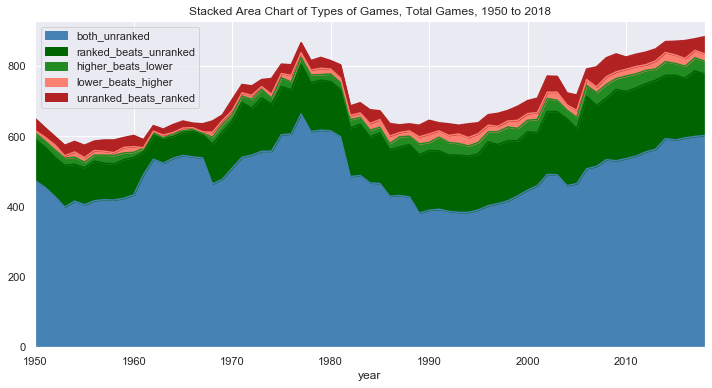

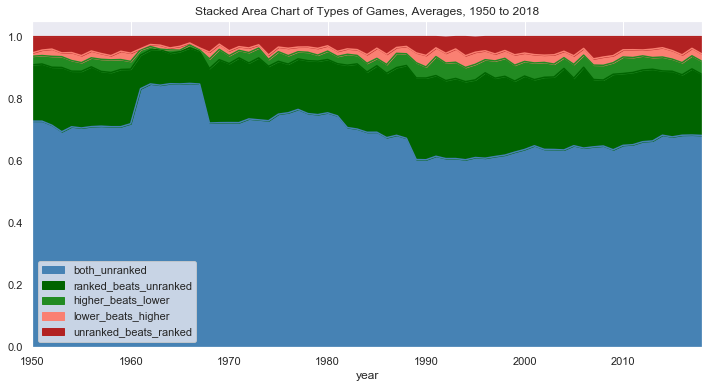

In [26]:
ax = ratios_sum.plot.area(figsize=(12,6), color=colors, title='Stacked Area Chart of Types of Games, Total Games, 1950 to 2018')
ax = ratios_mean.plot.area(figsize=(12,6), color=colors, title='Stacked Area Chart of Types of Games, Averages, 1950 to 2018')

However, these plots are still lacking in that there is a lot of information that is not easily accessible.  An interactive plot will make it easier to see this data.

In [27]:
x=ratios_sum.index.to_list()
 
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['both_unranked'],
    name='Both Unranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[0]),
    stackgroup='one' # define stack group
))
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['ranked_beats_unranked'],
    name='Ranked Beats Unranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[1]),
    stackgroup='one' # define stack group
))
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['higher_beats_lower'],
    name='Higher Beats Lower Ranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[2]),
    stackgroup='one' # define stack group
))
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['lower_beats_higher'],
    name='Lower Beats Higher Ranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[3]),
    stackgroup='one' # define stack group
))
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['unranked_beats_ranked'],
    name='Unranked Beats Ranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[4]),
    stackgroup='one' # define stack group
))
 
fig.update_layout(title="Stacked Area Chart of Types of Games, Total Games, 1950 to 2018")
fig.show()

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['both_unranked'],
    name='Both Unranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[0]),
    stackgroup='one', # define stack group
    groupnorm='percent'
))
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['ranked_beats_unranked'],
    name='Ranked Beats Unranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[1]),
    stackgroup='one', # define stack group
    groupnorm='percent'
))
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['higher_beats_lower'],
    name='Higher Beats Lower Ranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[2]),
    stackgroup='one', # define stack group
))
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['lower_beats_higher'],
    name='Lower Beats Higher Ranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[3]),
    stackgroup='one', # define stack group
    groupnorm='percent'
))
fig.add_trace(go.Scatter(
    x=x, y=ratios_sum['unranked_beats_ranked'],
    name='Unranked Beats Ranked',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color=colors[4]),
    stackgroup='one', # define stack group
    groupnorm='percent'
))
fig.update_layout(
    showlegend=True,
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))
fig.update_layout(title="Stacked Area Chart of Types of Games, Percentage, 1950 to 2018")
fig.show()

We can look for the most 'accurate' years by computing the correct answers (ranked beats unranked and higher beats lower divided by all games with ranked teams) and the incorrect answers (unranked beats ranked and lower beats higher divided by all games with ranked teams).  Then we can find the difference between the correct answers and incorrect answers to get a rough metric for accuracy.

In [29]:
ratios_years = ratios.groupby('year').mean()
ratios_years

both_unranked  ranked_beats_unranked  higher_beats_lower  \
year                                                             
1950       0.728111               0.181260            0.027650   
1951       0.728000               0.184000            0.027200   
1952       0.715000               0.186667            0.035000   
1953       0.693913               0.206957            0.034783   
1954       0.709898               0.179181            0.034130   
...             ...                    ...                 ...   
2014       0.682759               0.206897            0.044828   
2015       0.677382               0.211251            0.039036   
2016       0.682703               0.194731            0.038946   
2017       0.683371               0.212984            0.042141   
2018       0.682127               0.196833            0.041855   

      lower_beats_higher  unranked_beats_ranked  
year                                             
1950            0.010753               0.052227  
1951            0.017600               0.043200  
1952            0.023333               0.040000  
1953            0.012174               0.052174  
1954            0.025597               0.051195  
...                  ...                    ...  
2014            0.029885               0.035632  
2015            0.027555               0.044776  
2016            0.025200               0.058419  
2017            0.023918               0.037585  
2018            0.023756               0.055430  

[69 rows x 5 columns]

In [30]:
total = ratios_years['ranked_beats_unranked'] + ratios_years['higher_beats_lower'] + ratios_years['lower_beats_higher'] + ratios_years['unranked_beats_ranked']

In [31]:
ratios_years['correct'] = (ratios_years['ranked_beats_unranked'] + ratios_years['higher_beats_lower'])/total
ratios_years['incorrect'] = (ratios_years['lower_beats_higher'] + ratios_years['unranked_beats_ranked'])/total
ratios_years['accuracy'] = ratios_years['correct'] - ratios_years['incorrect']

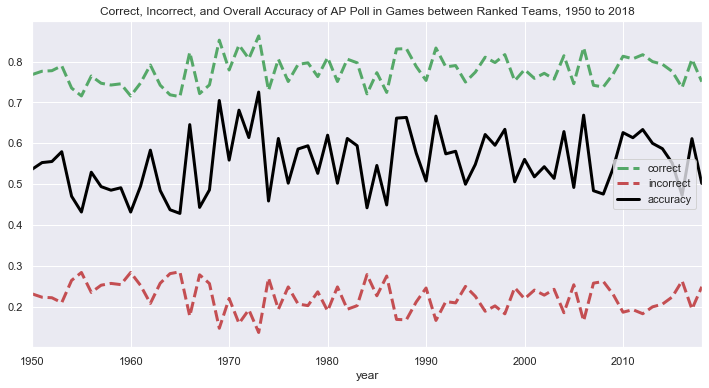

In [32]:
acc_df = ratios_years[['correct','incorrect','accuracy']]

acc_df.plot(figsize=(12,6), color=('g','r','black'), style=['--','--','-'], linewidth=3, 
            title="Correct, Incorrect, and Overall Accuracy of AP Poll in Games between Ranked Teams, 1950 to 2018")

In [33]:
acc_df.sort_values('accuracy')

correct  incorrect  accuracy
year                               
1965  0.714286   0.285714  0.428571
1960  0.715976   0.284024  0.431953
1955  0.715976   0.284024  0.431953
1964  0.718750   0.281250  0.437500
1984  0.721154   0.278846  0.442308
...        ...        ...       ...
1991  0.833333   0.166667  0.666667
2006  0.834507   0.165493  0.669014
1971  0.840580   0.159420  0.681159
1969  0.852459   0.147541  0.704918
1973  0.862745   0.137255  0.725490

[69 rows x 3 columns]

Looks like the worst years for accuracy were in the 60s.  College football at the time was still dealing with intense issues of segregation with many teams in the south still not allowing African-Americans to play.  Additionally, some of these teams did not want to play racially integrated teams.  This could be a reason for the inaccuracies of the polls.  

In [34]:
labels = ['Both Unranked', 'Ranked Beats Unranked', 'Higher Beats Lower Ranked',
       'Lower Bears Higher Ranked', 'Unranked Beats Ranked']

fig = go.Figure(data=[go.Pie(labels=labels, values=ratios.sum().to_list(), hole=.2, 
                             direction = 'clockwise', sort=False, )])
fig.update_traces(hoverinfo='label+value', textinfo='percent', textfont_size=16,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title="Pie Chart of Types of Team Interactions, 1950 to 2018")
fig.show()

In [35]:
def plot_pie(year):
    labels = ['Both Unranked', 'Ranked Beats Unranked', 'Higher Beats Lower Ranked',
       'Lower Bears Higher Ranked', 'Unranked Beats Ranked']

    fig = go.Figure(data=[go.Pie(labels=labels, values=ratios.groupby('year').mean().loc[year].to_list(), hole=.2, 
                                 direction = 'clockwise', sort=False, )])
    fig.update_traces(hoverinfo='label+value', textinfo='percent', textfont_size=16,
                      marker=dict(colors=colors, line=dict(color='#000000', width=2)))
    fig.update_layout(title="Pie Chart of Types of Team Interaction, {}".format(year))
    fig.show()

In [36]:
plot_pie(1965)

In [37]:
plot_pie(1973)

In [38]:
plot_pie(2018)